In [2]:
import os
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

from openretina.dataloaders import get_movie_dataloader
from openretina.hoefling_2022_data_io import gen_start_indices, natmov_dataloaders_v2
from openretina.hoefling_2022_models import SFB3d_core_SxF3d_readout
from openretina.misc import (
    CustomPrettyPrinter,
    load_dataset_from_h5,
    print_h5_structure,
)

%load_ext autoreload
%autoreload 2

In [3]:
# base_folder = Path("~/PhD_data").expanduser()
base_folder = Path("/Data/")

In [4]:
pp = CustomPrettyPrinter(indent=4)

In [5]:
!ls /Data/baccus_data/neural_code_data/ganglion_cell_data/

15-10-07  15-11-21a  15-11-21b


In [6]:
baccus_data_example_path = os.path.join(
    base_folder,
    "baccus_data/neural_code_data/ganglion_cell_data/15-10-07/naturalscene.h5",
)

In [ ]:
# print_h5_structure(baccus_data_example_path)

In [ ]:
train_video_baccus = load_dataset_from_h5(baccus_data_example_path, "/train/stimulus")
test_video_baccus = load_dataset_from_h5(baccus_data_example_path, "/test/stimulus")

In [ ]:
baccus_data_example_path_2 = os.path.join(
    base_folder,
    "baccus_data/neural_code_data/ganglion_cell_data/15-11-21b/naturalscene.h5",
)
train_video_baccus_2 = load_dataset_from_h5(baccus_data_example_path_2, "/train/stimulus")
test_video_baccus_2 = load_dataset_from_h5(baccus_data_example_path_2, "/test/stimulus")

In [ ]:
train_video_baccus = train_video_baccus[None, :]
train_video_baccus.shape

Regarding the stimuli used:

    A video monitor projected the visual stimuli at 30 Hz controlled by Matlab (Mathworks), using Psychophysics Toolbox.54 Stimuli had a constant mean intensity of 10 mW/m2. Images were presented in a 50 x 50 grid with a square size of 50 mm. Static natural jittered scenes consisted of images drawn from a natural image database.55 To create images for presentation to the retina, original color images were converted to grayscale, and were scaled to have minimum and maximum pixel intensities that matched that of the monitor. Pixel regions of 50 x 50 size were then selected from each image at a random location without spatial averaging for presentation.
    
So it is natural images, not videos. Also, regarding stimulus presentation:

    The image also abruptly changed in a single frame to a different location every one second, representing saccades, although such transitions did not contain a sweeping shift in the image. Transitions occurred both between different locations in the same image and between different images.

In [ ]:
from openretina.plotting import play_stimulus

play_stimulus(torch.Tensor(train_video_baccus[:, :90]))

In [ ]:
train_response_baccus = load_dataset_from_h5(
    baccus_data_example_path, "/train/response/firing_rate_20ms"
)
test_response_baccus = load_dataset_from_h5(
    baccus_data_example_path, "/test/response/firing_rate_20ms"
)
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
plt.plot(train_response_baccus[8, :300])

Single "clip" length is 90 frames. (i.e. how long an image was shown for)

Response should be firing rate in Hz, calculated from the ephys trace with various time bins. In the paper they say to train the model "The response and stimulus were binned in 10 ms time bins."

Our response is also a firing rate, but inferred from the calcium trace using c2s. Given that they are using MEAs, the temporal resolution of the signal (and some of the binning they used) is much higher. 

However, we can still use the spikes they provided to get a similar binning to our data.

---
# Sample data input and model training on Salamander data

In [ ]:
movie_length = train_video_baccus.shape[1]
clip_length = 90

In [ ]:
sample_dataloader = get_movie_dataloader(
    train_video_baccus,
    train_response_baccus.T,  # Transpose the response to match the dataloader format
    roi_ids=np.arange(train_response_baccus.shape[0]),
    roi_coords=np.random.normal(0, 1, (train_response_baccus.shape[0], 2)),
    group_assignment=np.arange(train_response_baccus.shape[0]),
    split="train",
    start_indices=np.arange(0, train_video_baccus.shape[1], 90),
    scan_sequence_idx=None,
    chunk_size=60,
    batch_size=32,
    scene_length=90,
)

In [ ]:
normalising_fr = 5

In [ ]:
baccus_data_dict = {
    "test_session": {
        "responses_final": {
            "train": train_response_baccus / normalising_fr,
            "test": test_response_baccus / normalising_fr,
        },
        "stim_id": "salamander_natural",
    }
}
baccus_movie_dict = {"train": train_video_baccus, "test": test_video_baccus[None, ...]}

In [ ]:
from openretina.maheswaranathan_2023_data_io import load_all_sessions

In [ ]:
responses, stimuli = load_all_sessions(
    os.path.join(base_folder, "baccus_data/neural_code_data/ganglion_cell_data/"),
    fr_normalization=1,
)

In [ ]:
dataloaders = natmov_dataloaders_v2(
    responses,
    stimuli,
    train_chunk_size=50,
    batch_size=32,
    clip_length=90,
    num_clips=len(np.arange(0, movie_length // clip_length)),
    num_val_clips=20,
)

---

# Training

In [ ]:
from openretina.hoefling_2022_configs import model_config

model = SFB3d_core_SxF3d_readout(**model_config, dataloaders=dataloaders, seed=42)

In [ ]:
import wandb
from openretina.hoefling_2022_configs import trainer_config
from openretina.training import standard_early_stop_trainer

In [ ]:
wandb.login()
run = wandb.init(
    project="salamander_data_hoefling_2022_model",
    notes="First tests with mouse architecture on salamander image data.",
    tags=None,
    job_type=None,
    name=None,
)

wandb.config.update({**model_config, **trainer_config})

In [ ]:
test_score, val_score, output, model_state = standard_early_stop_trainer(
    model,
    dataloaders,
    max_epochs=1,
    seed=42,
    device="cuda",
    wandb_logger=run,
    **trainer_config,
)

In [ ]:
val_field = "15-10-07"
val_sample = next(iter(dataloaders["validation"][val_field]))

input_samples = val_sample.inputs
targets = val_sample.targets

model.eval()
model.cpu()

with torch.no_grad():
    reconstructions = model(input_samples.cpu(), val_field)
reconstructions = reconstructions.cpu().numpy().squeeze()

targets = targets.cpu().numpy().squeeze()

In [ ]:
targets.shape

In [ ]:
reconstructions.shape

In [ ]:
import seaborn as sns

neuron = 1
fig, axes = plt.subplots(4, 5, figsize=(20, 5), sharey="row", sharex="col")
for trace_chunk in range(targets.shape[0]):
    ax_idx_1 = trace_chunk // 5
    ax_idx_2 = trace_chunk % 5
    ax = axes[ax_idx_1, ax_idx_2]
    ax.plot(targets[trace_chunk, 30:, neuron], label="target")
    ax.plot(reconstructions[trace_chunk, :, neuron], label="prediction")

    # Set x and y labels for only outer subplots
    if ax_idx_1 == 2:  # Bottom row
        ax.set_xlabel("Frames")
    if ax_idx_2 == 0:  # Leftmost column
        ax.set_ylabel("Firing rate")

    # # Remove inner labels
    # if ax_idx_1 != 2:
    #     ax.set_xticklabels([])
    # if ax_idx_2 != 0:
    #     ax.set_yticklabels([])
    # Only turn on x-axis labels for the bottom row
    if ax_idx_1 == 2:
        ax.tick_params(labelbottom=True)
    else:
        ax.tick_params(labelbottom=False)

    # Only turn on y-axis labels for the leftmost column
    if ax_idx_2 == 0:
        ax.tick_params(labelleft=True)
    else:
        ax.tick_params(labelleft=False)

# Place the legend outside of the subplots
axes[0, 0].legend()

sns.despine()

wandb.log({"reconstruction": fig})
plt.tight_layout()

In [ ]:
wandb.finish()

In [ ]:
print(test_score)

In [ ]:
test_field = "15-10-07"
test_sample = next(iter(dataloaders["test"][test_field]))

input_samples = test_sample.inputs
targets = test_sample.targets

model.eval()
model.cpu()

with torch.no_grad():
    reconstructions = model(input_samples.cpu(), test_field)
reconstructions = reconstructions.cpu().numpy().squeeze()

targets = targets.cpu().numpy().squeeze()

In [ ]:
reconstructions.shape

In [ ]:
targets.shape

In [ ]:
window = 500
neuron = 2
plt.plot(np.arange(0, window), targets[:window, neuron], label="target")
plt.plot(
    np.arange(30, window + 30), reconstructions[:window, neuron], label="prediction"
)
plt.legend()

---

# Test resampling

In [46]:
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

Salamander data has 30 KHz sampling rate with MEAs, whereas we have ~7.8 Hz with Ca2+ imaging.

They take 10 or 20 ms bins (100 or 50 Hz) and than have to *downsample* this to match the 30 Hz movie framerate.

We effectively take 128 ms bins (given our 7.8125 Hz imaging speed) and then have to *upsample* it to match the 30 Hz movie framerate.

In [7]:
print_h5_structure(baccus_data_example_path)

{'spikes': {'cell01': 'h5.Dataset(shape=(43927,)), float64',
            'cell02': 'h5.Dataset(shape=(11819,)), float64',
            'cell03': 'h5.Dataset(shape=(12423,)), float64',
            'cell04': 'h5.Dataset(shape=(37662,)), float64',
            'cell05': 'h5.Dataset(shape=(10976,)), float64',
            'cell06': 'h5.Dataset(shape=(11654,)), float64',
            'cell07': 'h5.Dataset(shape=(17792,)), float64',
            'cell08': 'h5.Dataset(shape=(4566,)), float64',
            'cell09': 'h5.Dataset(shape=(36307,)), float64'},
 'test': {'repeats': {'cell01': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell02': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell03': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell04': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell05': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell06': 'h5.Dataset(shape=(5, 5997)), float64',
                   

In [109]:
sample_spike_times = load_dataset_from_h5(baccus_data_example_path, "/spikes/cell01")

In [110]:
bin_len = 0.128
hist, bin_edges = np.histogram(
    sample_spike_times, bins=np.arange(0, sample_spike_times[-1], bin_len)
)

(0.0, 10.0)

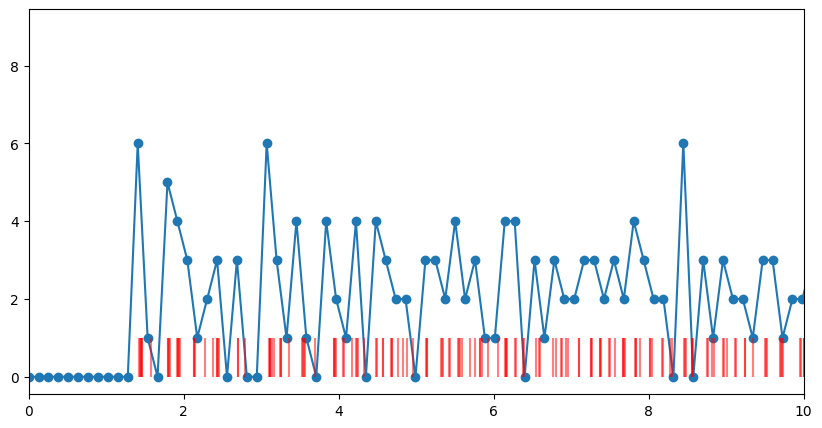

In [111]:
plt.figure(figsize=(10, 5))
plt.plot(bin_edges[:-1], hist, marker="o")
plt.vlines(sample_spike_times, 0, 1, color="r", alpha=0.5)
plt.xlim(0, 10)

In [112]:
interpolated_hist = interp1d(bin_edges[:-1], hist, kind="linear", bounds_error=False, fill_value="extrapolate")(
    np.arange(0, sample_spike_times[-1], 1 / 30)
)
interpolated_hist_corrected = interpolated_hist / interpolated_hist.std()

(0.0, 300.0)

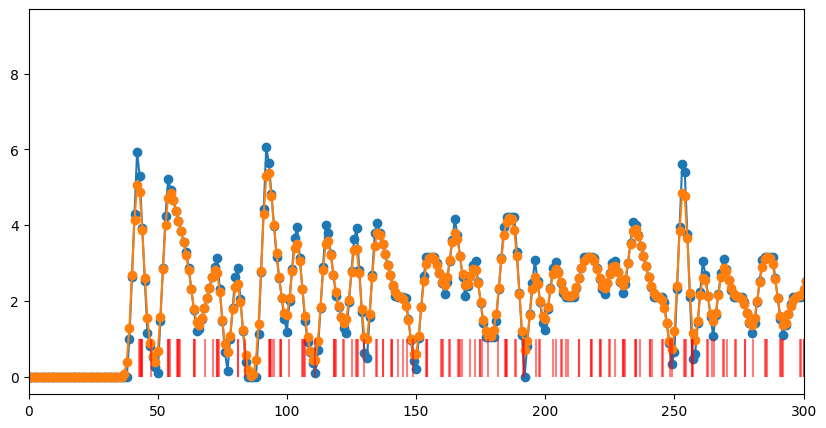

In [113]:
plt.figure(figsize=(10, 5))
plt.plot(interpolated_hist_corrected, marker="o")

plt.plot(gaussian_filter1d(interpolated_hist_corrected, sigma=1), marker="o")
plt.vlines(sample_spike_times * 30, 0, 1, color="r", alpha=0.5)
plt.xlim(0, 10 * 30)